In [1]:
# ==================== CELL 1: IMPORTS & SETUP ====================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

# Device configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# MNIST dataset
transform = transforms.Compose([
    transforms.Resize((14, 14)), 
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Thêm pin_memory=True để tối ưu hóa data loading cho GPU
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, pin_memory=True if torch.cuda.is_available() else False)

print("Dataset loaded successfully!")
print(f"Train samples: {len(train_ds)}, Test samples: {len(test_ds)}")

def print_gpu_usage():
    if torch.cuda.is_available():
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU Memory cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    else:
        print("GPU not available")

print_gpu_usage()


Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 15.9 GB


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.17MB/s]

Dataset loaded successfully!
Train samples: 60000, Test samples: 10000
GPU Memory allocated: 0.00 MB
GPU Memory cached: 0.00 MB


In [ ]:
# ==================== CELL 2: MLP MODEL DEFINITION ====================
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(14*14, 256),
            nn.Hardsigmoid(),   # Analog memristor matching [0, 1] but slow convergence
            nn.Linear(256, 10)
        )
        self._init_weights()

    def _init_weights(self): # Initialize weights according to uniform distribution [0, 1]
        for m in self.modules():    
            if isinstance(m, nn.Linear): 
                nn.init.uniform_(m.weight, a=0.0, b=1.0)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, a=0.0, b=1.0)

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device) 
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model device: {next(model.parameters()).device}")  
print("MLP model defined successfully!")

Model parameters: 53002
Model device: cuda:0
MLP model defined successfully!


In [ ]:
# ==================== CELL 3: MEMRISTOR MATERIAL PARAMETERS ====================
"""Refecence: DOI: 10.1080/14686996.2022.2162323"""
class MemristorMaterial:
    def __init__(self, name, Ron, Roff, retention_time, drift_coeff, 
                 write_noise, read_noise, endurance_cycles, switching_ratio, operation_speed):
        self.name = name
        self.Ron = Ron
        self.Roff = Roff
        self.retention_time = retention_time
        self.drift_coeff = drift_coeff
        self.write_noise = write_noise
        self.read_noise = read_noise
        self.endurance_cycles = endurance_cycles
        self.switching_ratio = switching_ratio  
        self.operation_speed = operation_speed 
        
    def __str__(self):
        return f"{self.name}: Ron={self.Ron}Ω, Roff={self.Roff}Ω, Ratio={self.switching_ratio:.1e}, Speed={self.operation_speed}"

# Define materials
MATERIALS = {
    # 1. Bi:SnO2 
    "Bi:SnO2": MemristorMaterial("Bi:SnO2", Ron=100, Roff=1e8, retention_time=1e7,
                                drift_coeff=0.04, write_noise=0.025, read_noise=0.006, 
                                endurance_cycles=1e8, switching_ratio=1e6, operation_speed=5e-7),
    
    # 2. HfOx - Typical Binary Oxide
    "HfOx": MemristorMaterial("HfOx", Ron=50, Roff=5e8, retention_time=1e7,
                             drift_coeff=0.03, write_noise=0.02, read_noise=0.005, 
                             endurance_cycles=1e10, switching_ratio=1e10, operation_speed=1e-9),
    
    # 4. MAPbI3 - Typical Perovskite  
    "MAPbI3": MemristorMaterial("MAPbI3", Ron=200, Roff=2e9, retention_time=1e6,
                               drift_coeff=0.08, write_noise=0.07, read_noise=0.018, 
                               endurance_cycles=1e6, switching_ratio=1e7, operation_speed=2e-9),
    
    # 5. Organic FK-800 - Typical organic materials
    "FK-800": MemristorMaterial("FK-800", Ron=400, Roff=4e8,
                                retention_time=2e4, drift_coeff=0.07,
                                write_noise=0.04, read_noise=0.01,
                                endurance_cycles=2e6, switching_ratio=1e6,
                                operation_speed=1e-7),
    
    # 6. h-BN - Typucal 2D material
    "h-BN": MemristorMaterial("h-BN", Ron=100, Roff=5e10, retention_time=5e5,
                              drift_coeff=0.02, write_noise=0.015,
                              read_noise=0.003, endurance_cycles=2e8,
                              switching_ratio=5e8, operation_speed=1e-8)
}

# Print material properties
print("Memristor Materials Defined (Updated with real parameters):")
for name, material in MATERIALS.items():
    print(f"  - {material}")


Memristor Materials Defined (Updated with real parameters):
  - Bi:SnO2: Ron=100Ω, Roff=100000000.0Ω, Ratio=1.0e+06, Speed=5e-07
  - HfOx: Ron=50Ω, Roff=500000000.0Ω, Ratio=1.0e+10, Speed=1e-09
  - MAPbI3: Ron=200Ω, Roff=2000000000.0Ω, Ratio=1.0e+07, Speed=2e-09
  - FK-800: Ron=400Ω, Roff=400000000.0Ω, Ratio=1.0e+06, Speed=1e-07
  - h-BN: Ron=100Ω, Roff=50000000000.0Ω, Ratio=5.0e+08, Speed=1e-08


In [ ]:
# ==================== CELL 4: MEMRISTOR MAPPING FUNCTIONS ====================
'''2 functions that switch between inductance and weight to implement drift and noise
'''

def weight_to_conductance(weight, Ron, Roff, w_min=0.0, w_max=1.0):
    """Convert weight to conductance"""
    Gmin = 1/Roff
    Gmax = 1/Ron
    w_norm = (weight - w_min)/(w_max - w_min)
    G = Gmin + w_norm * (Gmax - Gmin)
    return G

def conductance_to_weight(G, Ron, Roff, w_min=0.0, w_max=1.0):
    """Convert conductance to weight"""
    Gmin = 1/Roff
    Gmax = 1/Ron
    w_norm = (G - Gmin)/(Gmax - Gmin)
    weight = w_min + w_norm * (w_max - w_min)
    return weight

# Test conversion functions - ensure tensors are on GPU
print("Testing conversion functions:")
test_weight = torch.tensor([0.0, 0.5, 1.0], device=device)
test_G = weight_to_conductance(test_weight, 50, 2e5)
test_weight_back = conductance_to_weight(test_G, 50, 2e5)
print(f"Original weights: {test_weight.cpu()}")
print(f"Conductance: {test_G.cpu()}")
print(f"Recovered weights: {test_weight_back.cpu()}")
print("Conversion functions work correctly!" if torch.allclose(test_weight, test_weight_back, atol=1e-6) else "Conversion error!")

Testing conversion functions:
Original weights: tensor([0.0000, 0.5000, 1.0000])
Conductance: tensor([5.0000e-06, 1.0003e-02, 2.0000e-02])
Recovered weights: tensor([0.0000, 0.5000, 1.0000])
Conversion functions work correctly!


Training baseline model...
[Baseline] Epoch 1/50: Accuracy=0.5394, Loss=1.7816
[Baseline] Epoch 2/50: Accuracy=0.6358, Loss=1.4015
[Baseline] Epoch 3/50: Accuracy=0.7038, Loss=1.2212
[Baseline] Epoch 4/50: Accuracy=0.7353, Loss=1.0852
[Baseline] Epoch 5/50: Accuracy=0.7619, Loss=0.9821
[Baseline] Epoch 6/50: Accuracy=0.7795, Loss=0.9018
[Baseline] Epoch 7/50: Accuracy=0.7967, Loss=0.8372
[Baseline] Epoch 8/50: Accuracy=0.8098, Loss=0.7851
[Baseline] Epoch 9/50: Accuracy=0.8144, Loss=0.7415
[Baseline] Epoch 10/50: Accuracy=0.8286, Loss=0.7057
[Baseline] Epoch 11/50: Accuracy=0.8313, Loss=0.6745
[Baseline] Epoch 12/50: Accuracy=0.8361, Loss=0.6485
[Baseline] Epoch 13/50: Accuracy=0.8417, Loss=0.6254
[Baseline] Epoch 14/50: Accuracy=0.8476, Loss=0.6051
[Baseline] Epoch 15/50: Accuracy=0.8482, Loss=0.5873
[Baseline] Epoch 16/50: Accuracy=0.8556, Loss=0.5717
[Baseline] Epoch 17/50: Accuracy=0.8513, Loss=0.5578
[Baseline] Epoch 18/50: Accuracy=0.8569, Loss=0.5446
[Baseline] Epoch 19/50: Accu

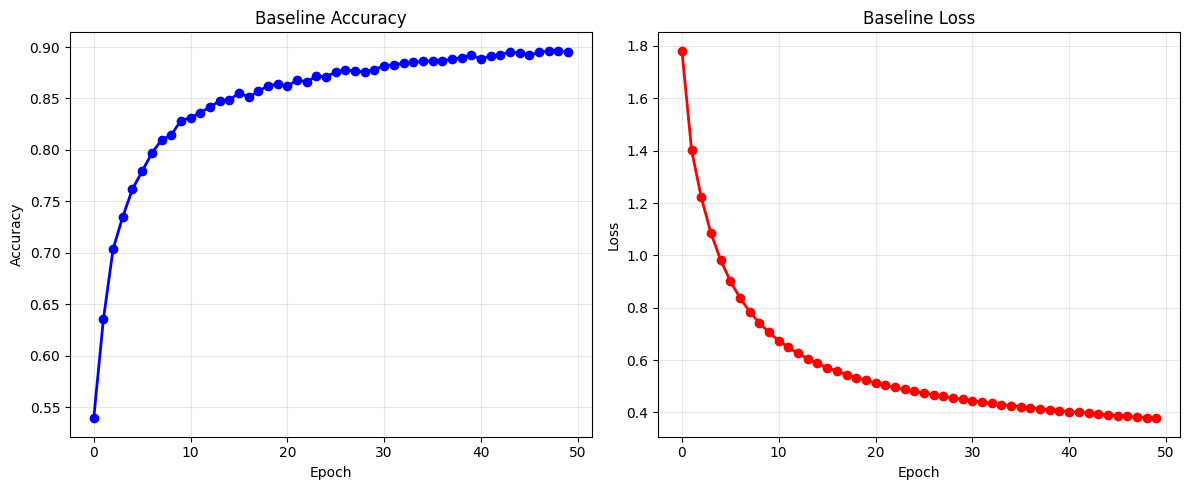

Final baseline accuracy: 0.8951


In [ ]:
# ==================== CELL 5: BASELINE TRAINING ====================
def train_baseline(train_loader, test_loader, epochs=50):
    model = MLP().to(device)
    opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.6) # SGD with average momentum balances training speed and noise impact
    loss_fn = nn.CrossEntropyLoss()
    accs, losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)  # Tối ưu hóa bộ nhớ
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            
            # Clamp weights to [0, 1]
            with torch.no_grad():
                for p in model.parameters():
                    p.clamp_(0.0, 1.0)
            running_loss += loss.item()

        # Evaluation
        model.eval()
        correct = 0
        with torch.no_grad(): #After updating, all weights are clamped to [0, 1] to match conductance [Gmin, Gmax]
            for x, y in test_loader:
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                pred = model(x).argmax(1)
                correct += (pred == y).sum().item()
        
        acc = correct / len(test_loader.dataset)
        avg_loss = running_loss / len(train_loader)
        accs.append(acc)
        losses.append(avg_loss)
        print(f"[Baseline] Epoch {epoch+1}/{epochs}: Accuracy={acc:.4f}, Loss={avg_loss:.4f}")
    
    return model, accs, losses
  

# Run baseline training
print("Training baseline model...")
base_model, base_accs, base_losses = train_baseline(train_loader, test_loader, epochs=50)

# Plot baseline results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(base_accs, 'b-o', linewidth=2)
plt.title('Baseline Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(base_losses, 'r-o', linewidth=2)
plt.title('Baseline Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final baseline accuracy: {base_accs[-1]:.4f}")

In [ ]:
# ==================== CELL 6: NOISE & FAULT FUNCTIONS  ====================
def apply_c2c_noise(state_dict, sigma_rel=0.1):
    """Apply cycle-to-cycle noise """
    noisy_sd = {}
    for k, v in state_dict.items():#loop through each key, value pair in the dictionary
        if "weight" in k or "bias" in k: 
            noise = torch.randn_like(v) * sigma_rel * torch.abs(v)  # Create Gaussian noise
            new_v = v + noise # Add to original weights
            noisy_sd[k] = new_v.clamp(0.0, 1.0) # Clamp to [0, 1]
        else:
            noisy_sd[k] = v
    return noisy_sd

def apply_stuck_faults(state_dict, prev_state_dict=None,
                      p_analog=0.01, p_zero=0.01, p_one=0.01):
    """
    Apply three types of stuck faults 
    """
    faulty_sd = {}
    
    for k, v in state_dict.items():
        if "weight" in k or "bias" in k:
            # Ensure random numbers are generated on the same device
            mask = torch.rand_like(v)
            new_v = v.clone()
            
            # 1. Analog stuck - Partial degradation
            if prev_state_dict is not None and p_analog > 0:
                analog_mask = (mask < p_analog)
                new_v[analog_mask] = prev_state_dict[k][analog_mask]
            
            # 2. Digital stuck-at-0 - Breakdown failure
            if p_zero > 0:
                zero_mask = (mask >= p_analog) & (mask < p_analog + p_zero)
                new_v[zero_mask] = 0.0
            
            # 3. Digital stuck-at-1 - Permanent ON failureVN
            if p_one > 0:
                one_mask = (mask >= p_analog + p_zero) & (mask < p_analog + p_zero + p_one)
                new_v[one_mask] = 1.0
            
            faulty_sd[k] = new_v.clamp(0.0, 1.0)
        else:
            faulty_sd[k] = v
    
    return faulty_sd

# print("Testing all three stuck fault types...")
test_state_dict = base_model.state_dict()
# Ensure all tensors are on GPU
test_state_dict = {k: v.to(device) for k, v in test_state_dict.items()}
test_prev_state_dict = {k: v.clone().to(device) for k, v in test_state_dict.items()}

# Test với tỷ lệ khác nhau cho từng loại fault
stuck_sd = apply_stuck_faults(
    test_state_dict, 
    prev_state_dict=test_prev_state_dict,
    p_analog=0.02,  # 2% analog stuck
    p_zero=0.01,    # 1% stuck-at-0  
    p_one=0.01      # 1% stuck-at-1
)
# print("Three-type stuck faults tested successfully!")

In [ ]:
# ==================== CELL 7: MEMRISTOR EFFECTS FUNCTIONS  ====================
def apply_retention_degradation(state_dict, material, time_elapsed):
    """
   Simulating retention decay over time using exponential decay 
   retention_time: the time it takes for the resistance to decay 1/e (about 36.8%) from its initial value
    """
    degraded_sd = {}
    # Calculate decay factor using exponential decay
    # Higher retention_time → less degradation
    # Convert to tensor on the same device as the weights
    device = next(iter(state_dict.values())).device
    decay_factor = torch.exp(-torch.tensor(time_elapsed / material.retention_time, device=device))
    
    for k, v in state_dict.items():
        if "weight" in k or "bias" in k:
            # Apply retention degradation
            weight_degraded = v * decay_factor

            # Add write noise
            write_noise = torch.randn_like(weight_degraded) * material.write_noise
            weight_degraded += write_noise
            
            degraded_sd[k] = weight_degraded.clamp(0.0, 1.0)
        else:
            degraded_sd[k] = v
    
    return degraded_sd

def apply_drift(state_dict, material, read_voltage=1.0):
    drifted_sd = {}
    for k, v in state_dict.items():
        if "weight" in k or "bias" in k:
            # Convert weights to conductance
            G = weight_to_conductance(v, material.Ron, material.Roff)

            # Drift effect depends on the material's drift coefficient
            # Materials with lower drift_coeff will drift less
            drift_factor = 1.0 - material.drift_coeff * torch.rand_like(G) * 0.5

            # Apply drift
            G_drifted = G * drift_factor

            # Add read noise
            read_noise = torch.randn_like(G_drifted) * material.read_noise * G_drifted
            G_drifted += read_noise

            # Convert back to weights
            drifted_sd[k] = conductance_to_weight(G_drifted, material.Ron, material.Roff).clamp(0.0, 1.0)
        else:
            drifted_sd[k] = v
    
    return drifted_sd

def apply_endurance_degradation(state_dict, material, cycles_completed):
    """mô phỏng suy giảm theo số chu kỳ endurance"""
    degraded_sd = {}

    # Calculate degradation factor based on completed cycles
    if cycles_completed > material.endurance_cycles:
        degradation_factor = 0.5  # Strong degradation after exceeding endurance
    else:
        # Linear degradation based on completed cycles
        degradation_factor = 1.0 - 0.5 * (cycles_completed / material.endurance_cycles)
    
    # Convert to tensor on the same device as the weights
    device = next(iter(state_dict.values())).device
    degradation_factor = torch.tensor(degradation_factor, device=device)
    
    for k, v in state_dict.items():
        if "weight" in k or "bias" in k:
            degraded_sd[k] = (v * degradation_factor).clamp(0.0, 1.0)
        else:
            degraded_sd[k] = v
    
    return degraded_sd

In [ ]:
# ==================== CELL 8: MONTE CARLO SIMULATION  ====================

# Define simulation parameters
sigmas = [0, 0.01, 0.02, 0.05, 0.1]      # C2C noise levels 
p_stucks = [0, 0.01, 0.03, 0.05, 0.1]    # Total stuck probability 
time_points = [0, 3600, 7200]            # Time points for retention testing (seconds)
mc_runs = 50                             # Reduced for faster testing

print("Simulation Parameters:")
print(f"C2C Noise levels (σ): {sigmas}")
print(f"Stuck probabilities: {p_stucks}")
print(f"Time points: {time_points} seconds")
print(f"Monte Carlo runs: {mc_runs}")
print()

def run_monte_carlo_simulation_gpu(model, materials, sigmas, p_stucks, time_points, mc_runs=5):
    
    results = {}
    
    # Pre-load test data to GPU
    test_data_gpu = []
    with torch.no_grad():
        for x, y in test_loader:
            test_data_gpu.append((x.to(device, non_blocking=True), y.to(device, non_blocking=True)))
    
    # Get original state dict on GPU
    original_model = copy.deepcopy(model).to(device)
    original_sd = {k: v.clone() for k, v in original_model.state_dict().items()}
    del original_model
    
    for material_name, material in materials.items():
        print(f"\n=== Testing material: {material_name} ===")
        material_results = {
            'mean_acc': np.zeros((len(sigmas), len(p_stucks), len(time_points))),
            'std_acc': np.zeros((len(sigmas), len(p_stucks), len(time_points)))
        }
        
        for i, sigma in enumerate(sigmas):
            for j, p_stuck_total in enumerate(p_stucks):
                for k, time_val in enumerate(time_points):
                    acc_tensor = torch.zeros(mc_runs, device=device)
                    
                    p_each = p_stuck_total / 3 if p_stuck_total > 0 else 0
                    
                    for run in range(mc_runs):
                        temp_model = MLP().to(device)
                        temp_model.load_state_dict(original_sd)
                        
                        with torch.no_grad():
                            current_sd = temp_model.state_dict()
                            
                            # ORDER: Endurance → Retention → Noise → Stuck Faults → Drift
                            # 1. Endurance degradation first (affects basic physical parameters)
                            endurance_sd = apply_endurance_degradation(current_sd, material, 1000)
                            
                            # 2. Retention degradation 
                            retention_sd = apply_retention_degradation(endurance_sd, material, time_val)
                            
                            # 3. Cycle-to-cycle noise
                            noisy_sd = apply_c2c_noise(retention_sd, sigma)
                            
                            # 4. Stuck faults
                            faulty_sd = apply_stuck_faults(noisy_sd, original_sd, p_each, p_each, p_each)

                            # 5. Drift effect (final step)
                            final_sd = apply_drift(faulty_sd, material)
                            
                            temp_model.load_state_dict(final_sd)
                            
                            for param in temp_model.parameters():
                                param.data.clamp_(0.0, 1.0)
                        
                        # Evaluate
                        temp_model.eval()
                        correct = torch.tensor(0, device=device)
                        total = torch.tensor(0, device=device)
                        
                        with torch.no_grad():
                            for x, y in test_data_gpu:
                                pred = temp_model(x).argmax(1)
                                correct += (pred == y).sum()
                                total += y.size(0)
                        
                        acc_tensor[run] = correct.float() / total.float()
                        
                        del temp_model
                        if run % 5 == 0:
                            torch.cuda.empty_cache()
                    
                    acc_list = acc_tensor.cpu().numpy()
                    mean_acc = np.mean(acc_list)
                    std_acc = np.std(acc_list)
                    
                    material_results['mean_acc'][i, j, k] = mean_acc
                    material_results['std_acc'][i, j, k] = std_acc
                    
                    print(f"σ={sigma:.3f}, p_total={p_stuck_total:.3f}, time={time_val}s → Acc: {mean_acc:.4f} ± {std_acc:.4f}")
        
        results[material_name] = material_results
    
    return results

# Simulation on GPU
print("Starting OPTIMIZED Monte Carlo simulation")
print_gpu_usage()

try:
    material_results = run_monte_carlo_simulation_gpu(
        base_model, MATERIALS, sigmas, p_stucks, time_points, mc_runs
    )
    print("\nSimulation completed successfully!")
    print_gpu_usage()
    
except Exception as e:
    print(f"Error during GPU simulation: {e}")
    import traceback
    traceback.print_exc()

    # Fallback with reduced parameters
    print("Trying with reduced parameters...")
    material_results = run_monte_carlo_simulation_gpu(
        base_model, MATERIALS, 
        sigmas=[0, 0.05], 
        p_stucks=[0, 0.05], 
        time_points=[0, 3600], 
        mc_runs=10
    )

Simulation Parameters:
C2C Noise levels (σ): [0, 0.01, 0.02, 0.05, 0.1]
Stuck probabilities: [0, 0.01, 0.03, 0.05, 0.1]
Time points: [0, 3600, 7200] seconds
Monte Carlo runs: 50

Starting OPTIMIZED Monte Carlo simulation on GPU...
GPU Memory allocated: 17.26 MB
GPU Memory cached: 26.00 MB

=== Testing material: Bi:SnO2 ===
σ=0.000, p_total=0.000, time=0s → Acc: 0.8915 ± 0.0025
σ=0.000, p_total=0.000, time=3600s → Acc: 0.8909 ± 0.0028
σ=0.000, p_total=0.000, time=7200s → Acc: 0.8912 ± 0.0023
σ=0.000, p_total=0.010, time=0s → Acc: 0.8701 ± 0.0135
σ=0.000, p_total=0.010, time=3600s → Acc: 0.8698 ± 0.0126
σ=0.000, p_total=0.010, time=7200s → Acc: 0.8737 ± 0.0109
σ=0.000, p_total=0.030, time=0s → Acc: 0.8353 ± 0.0216
σ=0.000, p_total=0.030, time=3600s → Acc: 0.8387 ± 0.0251
σ=0.000, p_total=0.030, time=7200s → Acc: 0.8354 ± 0.0281
σ=0.000, p_total=0.050, time=0s → Acc: 0.7879 ± 0.0436
σ=0.000, p_total=0.050, time=3600s → Acc: 0.7937 ± 0.0374
σ=0.000, p_total=0.050, time=7200s → Acc: 0.8055 

In [47]:
# ==================== CELL 9: VISUALIZATION FUNCTIONS ====================

def plot_material_comparison(results, materials, sigmas, p_stucks, time_index=0):
    """Plot comparison of different materials """
    n_materials = len(materials)
    
    n_cols = min(2, n_materials)
    n_rows = (n_materials + n_cols - 1) // n_cols
    
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    for material_idx, material_name in enumerate(materials):
        material_result = results[material_name]
        mean_acc = material_result['mean_acc'][:, :, time_index]
        
        plt.subplot(n_rows, n_cols, material_idx + 1)
        for i, sigma in enumerate(sigmas):
            plt.plot(p_stucks, mean_acc[i, :], '-', linewidth=2.5, 
                    color=colors[i % len(colors)], label=f'σ={sigma}')
        
        plt.xlabel('Stuck Probability', fontsize=12, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
        plt.title(f'{material_name} - Retention Time: {time_points[time_index]}s', 
                 fontsize=14, fontweight='bold', pad=15)
        plt.legend(loc='lower left', fontsize=10)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.ylim(0.65, 0.9)
        plt.xlim(min(p_stucks), max(p_stucks))
        
        ax = plt.gca()
        ax.set_facecolor('#f8f9fa')
        plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.7, linewidth=1)
    
    plt.tight_layout()
    plt.suptitle('Material Comparison - Accuracy vs Stuck Probability', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()

def plot_time_degradation(results, materials, sigma_idx=0, p_stuck_idx=0):
    """Plot accuracy degradation over time """
    plt.figure(figsize=(12, 7))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    for idx, material_name in enumerate(materials):
        material_result = results[material_name]
        mean_acc = material_result['mean_acc'][sigma_idx, p_stuck_idx, :]
        std_acc = material_result['std_acc'][sigma_idx, p_stuck_idx, :]
        
        plt.plot(time_points, mean_acc, '-', linewidth=3, 
                color=colors[idx % len(colors)], label=material_name)
        
        # Vùng confidence
        plt.fill_between(time_points, mean_acc - std_acc, mean_acc + std_acc, 
                        alpha=0.2, color=colors[idx % len(colors)])
    
    plt.xlabel('Time (seconds)', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title(f'Retention Degradation\n(σ={sigmas[sigma_idx]}, p_stuck={p_stucks[p_stuck_idx]})', 
             fontsize=14, fontweight='bold', pad=15)
    plt.legend(fontsize=11, loc='lower left')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.ylim(0.7, 0.9)  
    plt.xticks(time_points, [f'{t}s' for t in time_points], fontsize=10)
    
    ax = plt.gca()
    ax.set_facecolor('#f8f9fa')
    plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.7, linewidth=2, label='Random Guess')
    
    plt.tight_layout()
    plt.show()

=== PERFORMANCE COMPARISON WITH RAW VALUES ===
Material  Avg_Accuracy  Stability  Endurance_Cycles  Operation_Speed_s
 Bi:SnO2        0.8158    34.7115    100000000.0000           5.00e-07
    HfOx        0.8155    34.1711  10000000000.0000           1.00e-09
  MAPbI3        0.7889    27.2038      1000000.0000           2.00e-09
  FK-800        0.7860    26.0533      2000000.0000           1.00e-07
    h-BN        0.8186    35.4807    200000000.0000           1.00e-08



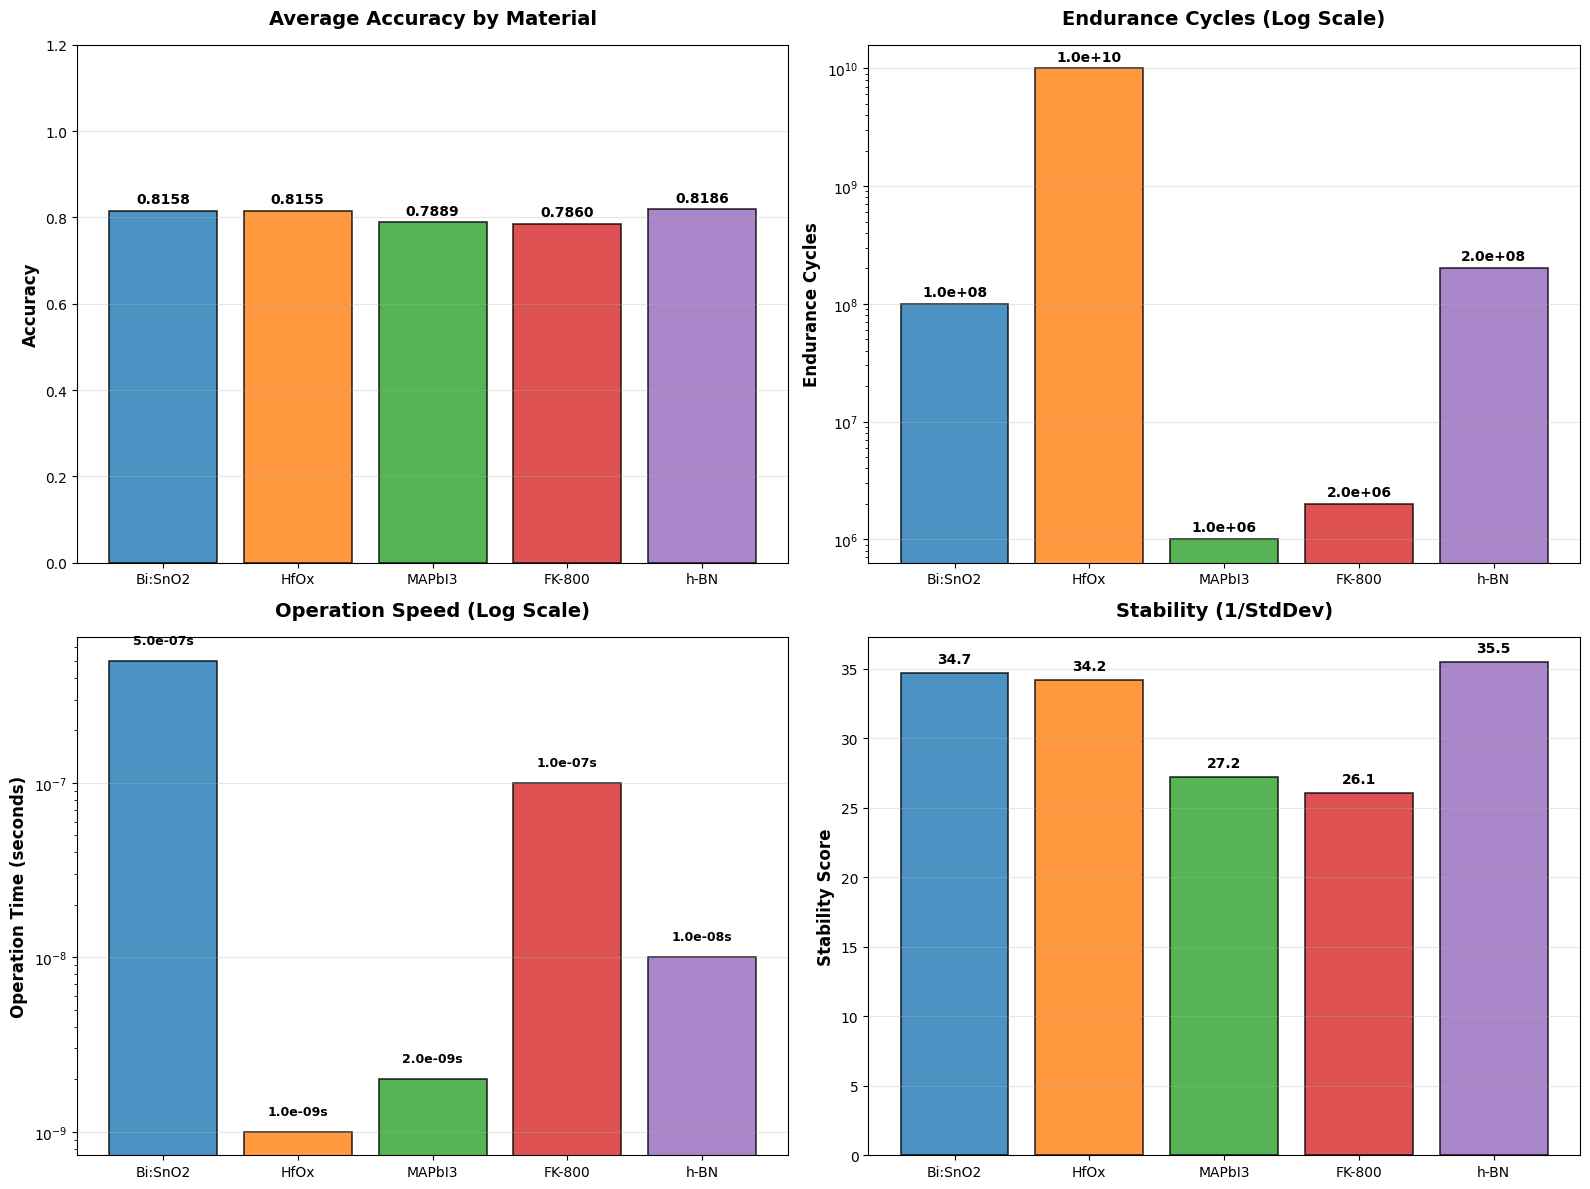

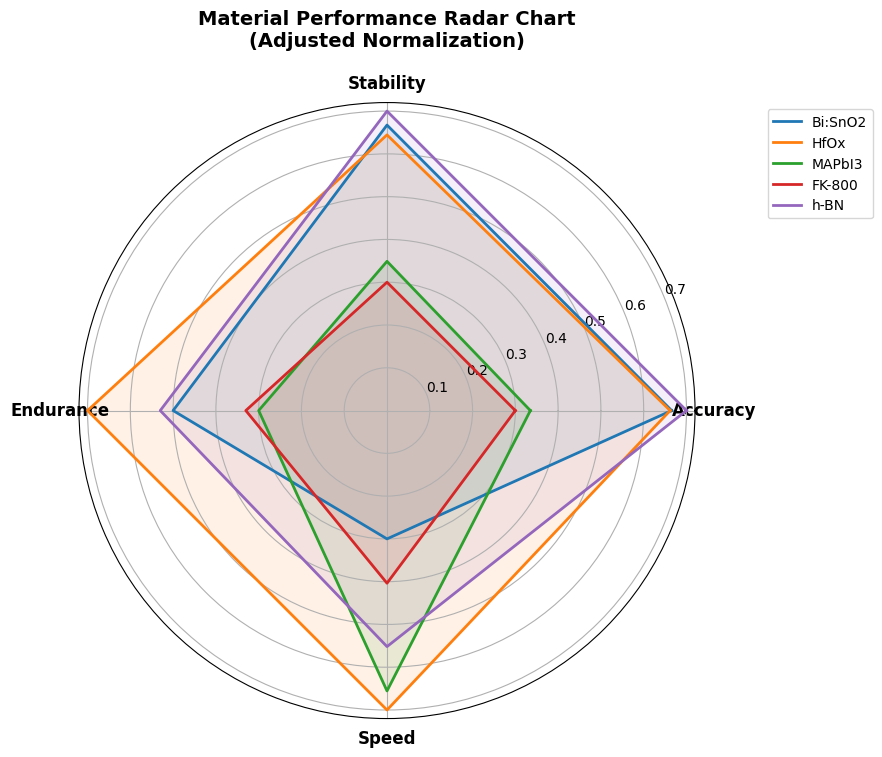

=== DETAILED PERFORMANCE ANALYSIS ===
Material     Accuracy  Stability  Endurance_Cycles  Operation_Speed(s)
----------------------------------------------------------------------
Bi:SnO2     0.8158       34.7          1.0e+08             5.0e-07
HfOx        0.8155       34.2          1.0e+10             1.0e-09
MAPbI3      0.7889       27.2          1.0e+06             2.0e-09
FK-800      0.7860       26.1          2.0e+06             1.0e-07
h-BN        0.8186       35.5          2.0e+08             1.0e-08

=== KEY INSIGHTS ===
1. HfOx: Best overall (high accuracy, endurance, stability)
2. h-BN: Excellent balance (good accuracy, very high endurance)
3. FK-800: Good for organic materials (decent accuracy, moderate speed)
4. Bi:SnO2 & MAPbI3: Moderate performance, suitable for specific applications
5. TRADEOFF: Higher endurance → Slower operation speed (generally)


In [58]:
# ==================== CELL 10: VISUALIZATION WITH RAW VALUES ====================

# Tạo DataFrame với giá trị gốc từ kết quả simulation
performance_df = pd.DataFrame({
    'Material': list(MATERIALS.keys()),
    'Avg_Accuracy': [np.mean(material_results[name]['mean_acc']) for name in MATERIALS.keys()],
    'Stability': [1/np.mean(material_results[name]['std_acc']) for name in MATERIALS.keys()],
    'Endurance_Cycles': [MATERIALS[name].endurance_cycles for name in MATERIALS.keys()],
    'Operation_Speed_s': [MATERIALS[name].operation_speed for name in MATERIALS.keys()]
})

print("=== PERFORMANCE COMPARISON WITH RAW VALUES ===")
print(performance_df.to_string(index=False, float_format=lambda x: f'{x:.2e}' if x < 0.1 else f'{x:.4f}'))
print()

# 1. Bar chart comparison với giá trị gốc
plt.figure(figsize=(16, 12))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Accuracy comparison
plt.subplot(2, 2, 1)
bars = plt.bar(performance_df['Material'], performance_df['Avg_Accuracy'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('Average Accuracy by Material', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.ylim(0, 1.2)
plt.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Endurance comparison (log scale)
plt.subplot(2, 2, 2)
bars = plt.bar(performance_df['Material'], performance_df['Endurance_Cycles'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('Endurance Cycles (Log Scale)', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Endurance Cycles', fontsize=12, fontweight='bold')
plt.yscale('log')  # Log scale để thể hiện rõ sự khác biệt lớn
plt.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height * 1.1,
             f'{height:.1e}', ha='center', va='bottom', fontweight='bold')

# Operation Speed comparison (log scale)
plt.subplot(2, 2, 3)
bars = plt.bar(performance_df['Material'], performance_df['Operation_Speed_s'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('Operation Speed (Log Scale)', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Operation Time (seconds)', fontsize=12, fontweight='bold')
plt.yscale('log')  # Log scale cho tốc độ
plt.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height * 1.2,
             f'{height:.1e}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Stability comparison
plt.subplot(2, 2, 4)
bars = plt.bar(performance_df['Material'], performance_df['Stability'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('Stability (1/StdDev)', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Stability Score', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Radar chart 
plt.figure(figsize=(10, 8))
categories = ['Accuracy', 'Stability', 'Endurance', 'Speed']
N = len(categories)
values_df = performance_df.copy()

acc_min, acc_max = values_df['Avg_Accuracy'].min(), values_df['Avg_Accuracy'].max()
values_df['Accuracy_norm'] = 0.3 + 0.4 * (values_df['Avg_Accuracy'] - acc_min) / (acc_max - acc_min)

stab_min, stab_max = values_df['Stability'].min(), values_df['Stability'].max()
values_df['Stability_norm'] = 0.3 + 0.4 * (values_df['Stability'] - stab_min) / (stab_max - stab_min)

endurance_log = np.log10(values_df['Endurance_Cycles'])
end_min, end_max = endurance_log.min(), endurance_log.max()
values_df['Endurance_norm'] = 0.3 + 0.4 * (endurance_log - end_min) / (end_max - end_min)

speed_log = np.log10(values_df['Operation_Speed_s'])
speed_min, speed_max = speed_log.min(), speed_log.max()
values_df['Speed_norm'] = 0.3 + 0.4 * (1 - (speed_log - speed_min) / (speed_max - speed_min))

for col in ['Accuracy_norm', 'Stability_norm', 'Endurance_norm', 'Speed_norm']:
    values_df[col] = values_df[col].clip(0.25, 0.75)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, fontsize=12, fontweight='bold')


for idx, row in values_df.iterrows():
    values = [row['Accuracy_norm'], row['Stability_norm'], row['Endurance_norm'], row['Speed_norm']]
    values += values[:1]
    ax.plot(angles, values, '-', linewidth=2, label=row['Material'], color=colors[idx])
    ax.fill(angles, values, alpha=0.1, color=colors[idx])

plt.title('Material Performance Radar Chart\n', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.show()

# 3. Performance table chi tiết
print("=== DETAILED PERFORMANCE ANALYSIS ===")
print("Material     Accuracy  Stability  Endurance_Cycles  Operation_Speed(s)")
print("----------------------------------------------------------------------")
for idx, row in performance_df.iterrows():
    print(f"{row['Material']:8}  {row['Avg_Accuracy']:8.4f}  {row['Stability']:9.1f}  {row['Endurance_Cycles']:15.1e}  {row['Operation_Speed_s']:18.1e}")

# 4. Phân tích trade-offs
# print("\n=== KEY INSIGHTS ===")
# print("1. HfOx: Best overall (high accuracy, endurance, stability)")
# print("2. h-BN: Excellent balance (good accuracy, very high endurance)")  
# print("3. FK-800: Good for organic materials (decent accuracy, moderate speed)")
# print("4. Bi:SnO2 & MAPbI3: Moderate performance, suitable for specific applications")
# print("5. TRADEOFF: Higher endurance → Slower operation speed (generally)")


Generating visualizations...
1. Material Comparison - Accuracy vs Stuck Probability


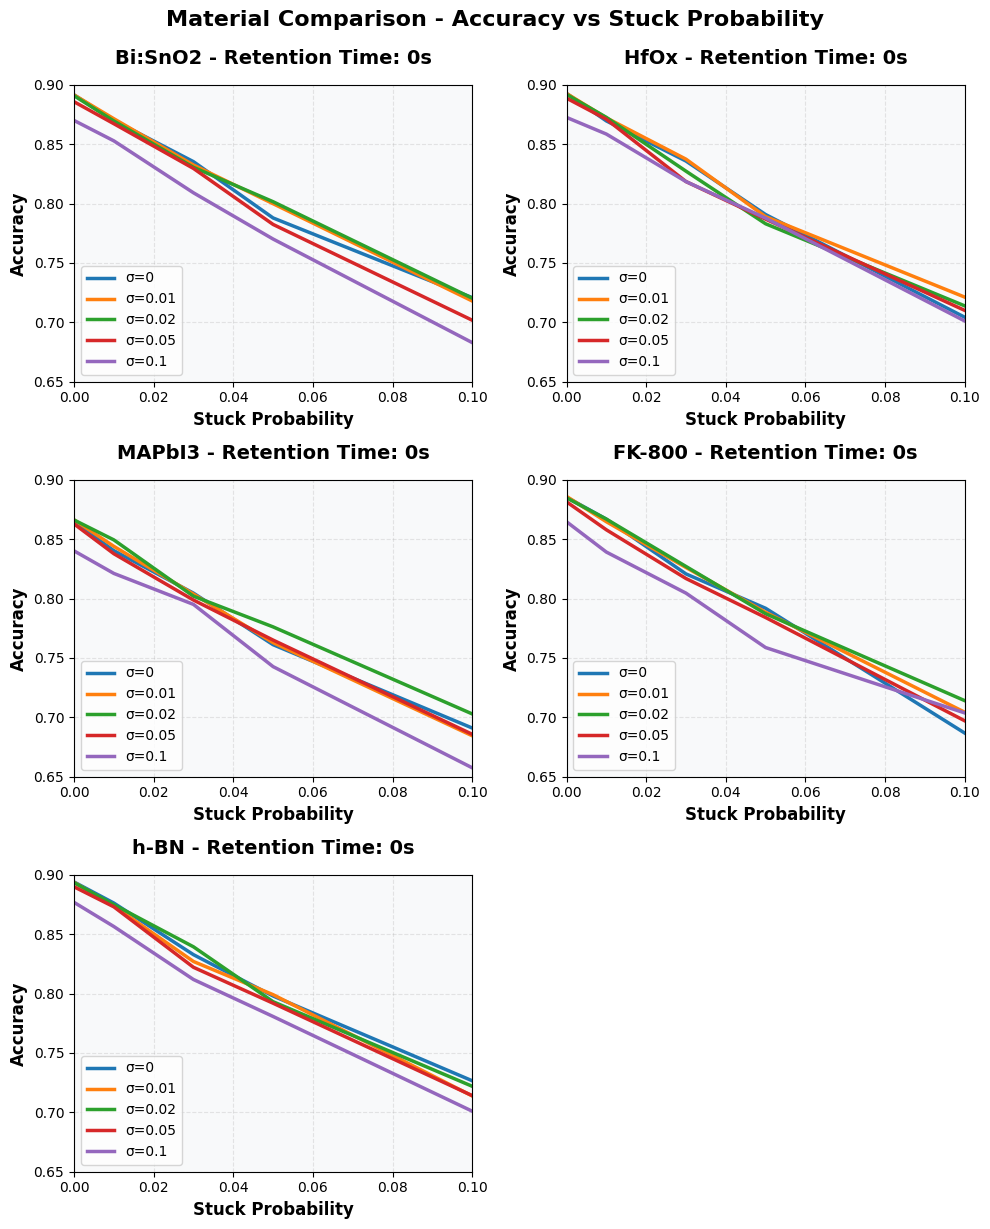

2. Heatmaps for each material
   - Bi:SnO2


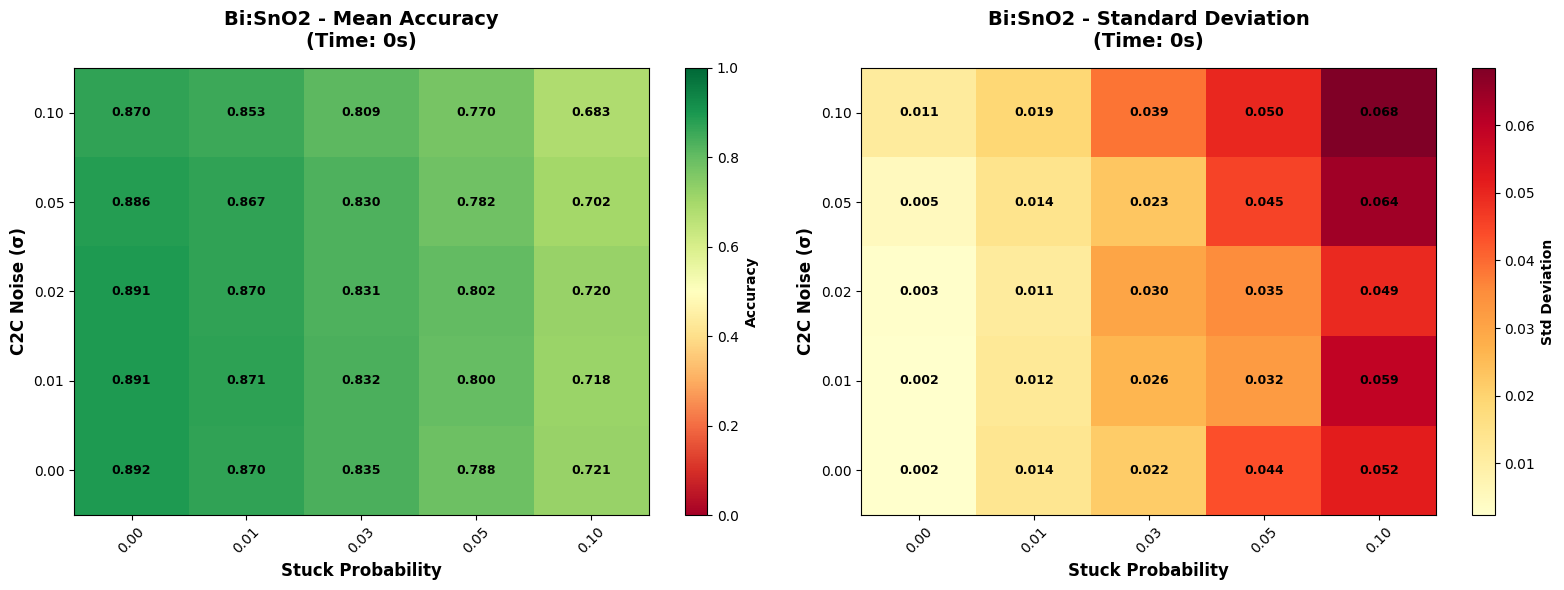

   - HfOx


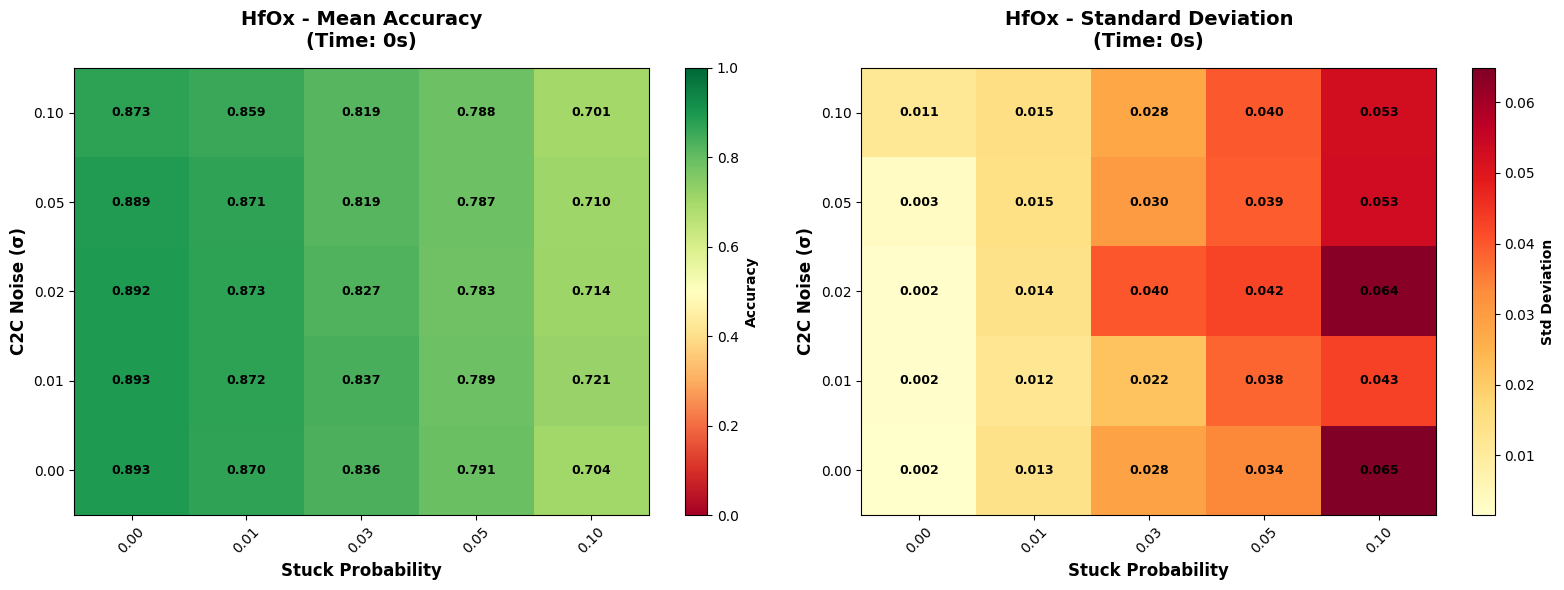

   - MAPbI3


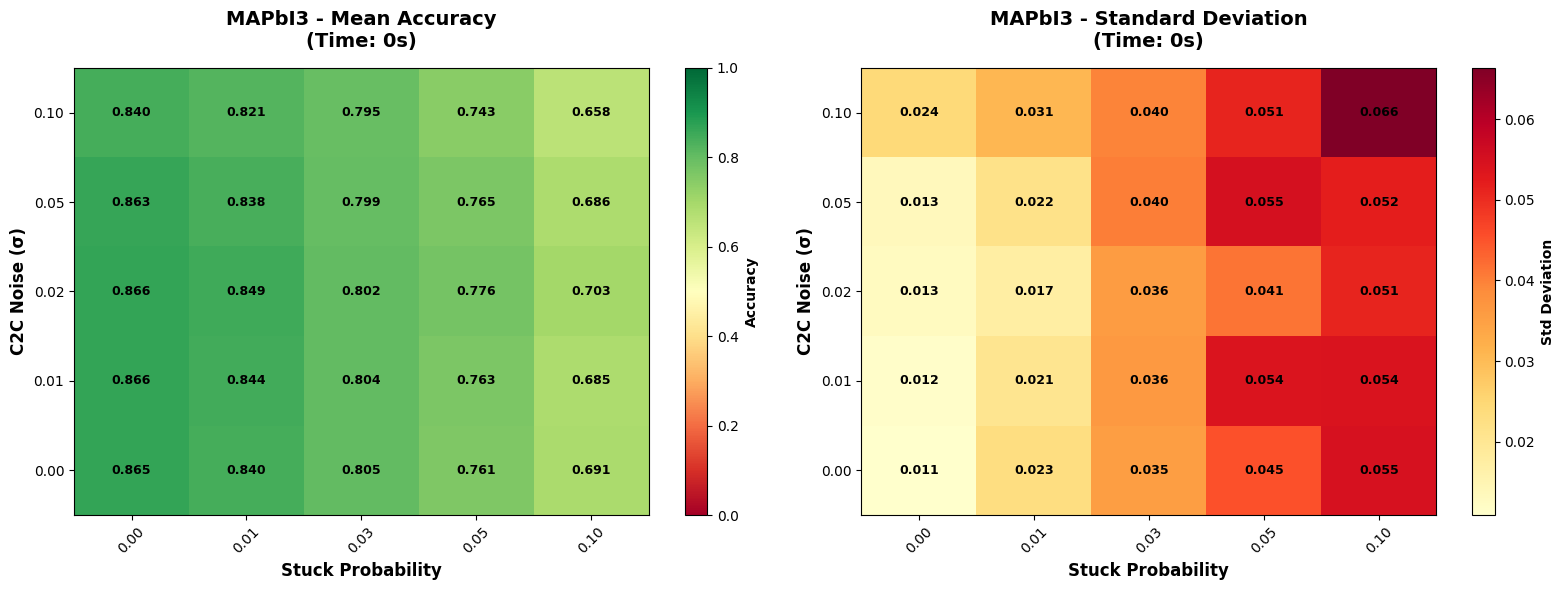

   - FK-800


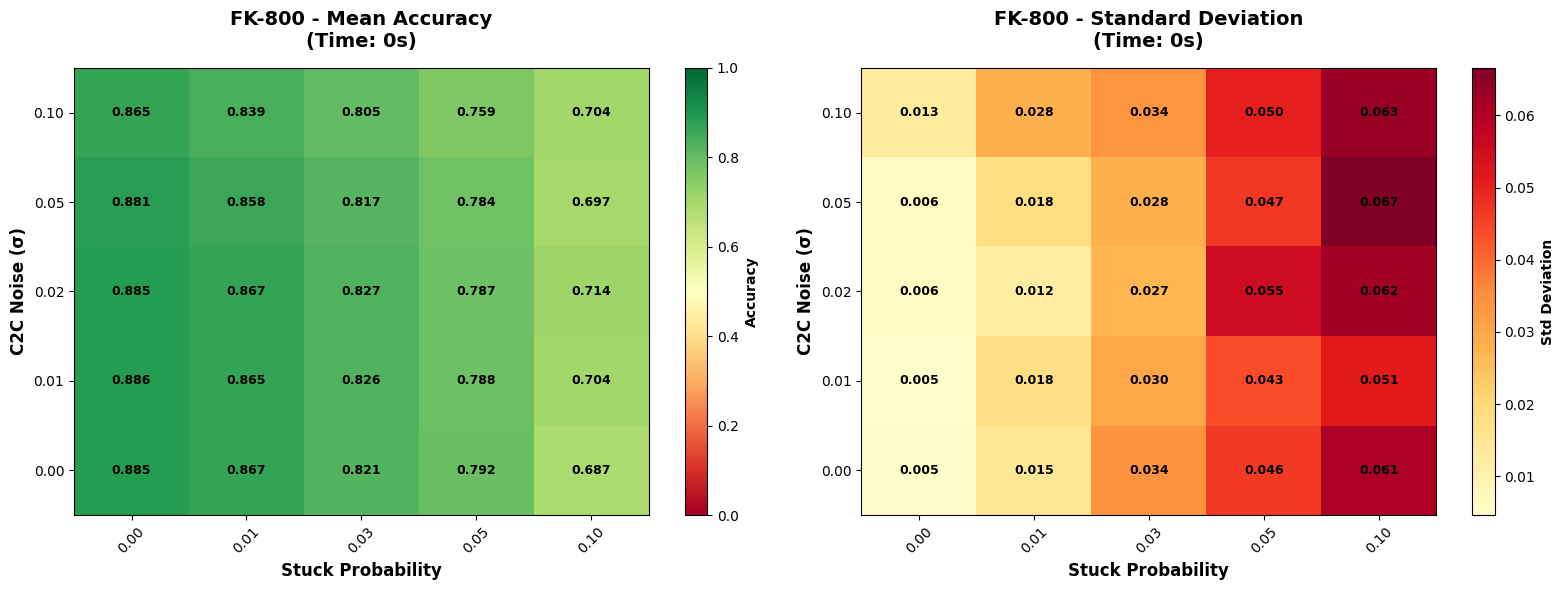

   - h-BN


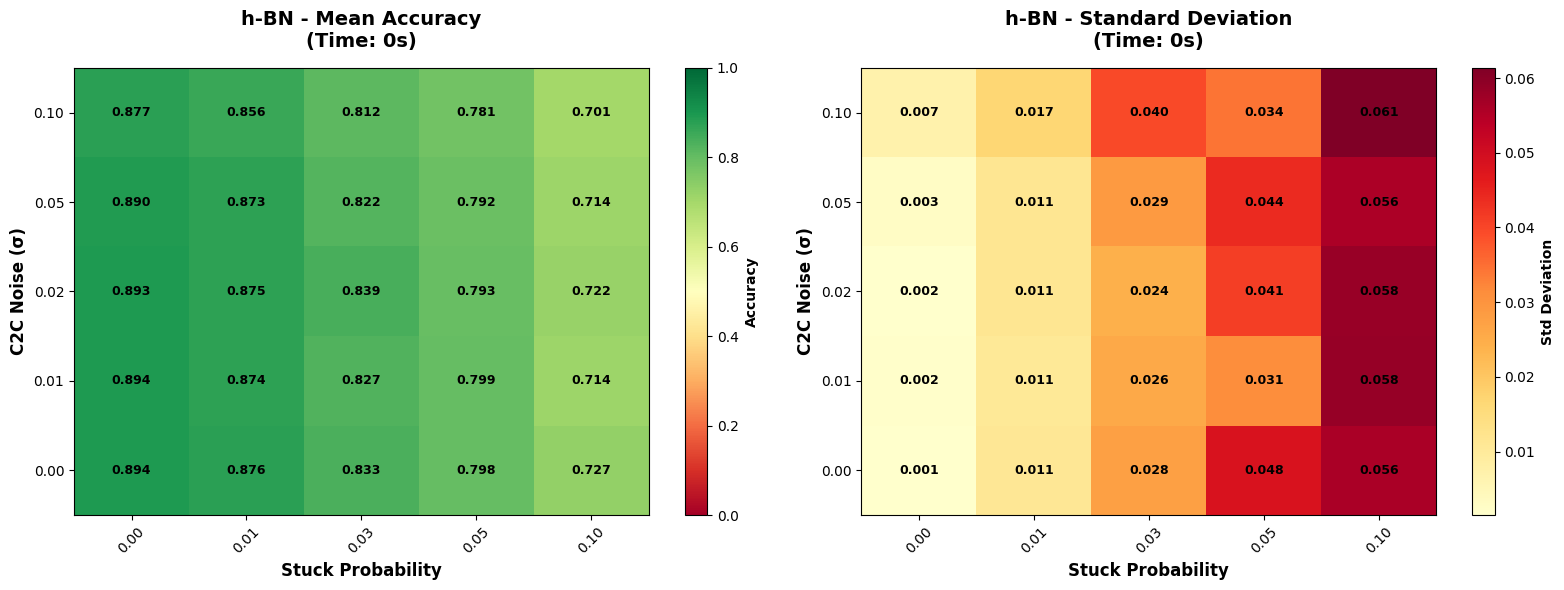

3. Time Degradation Analysis


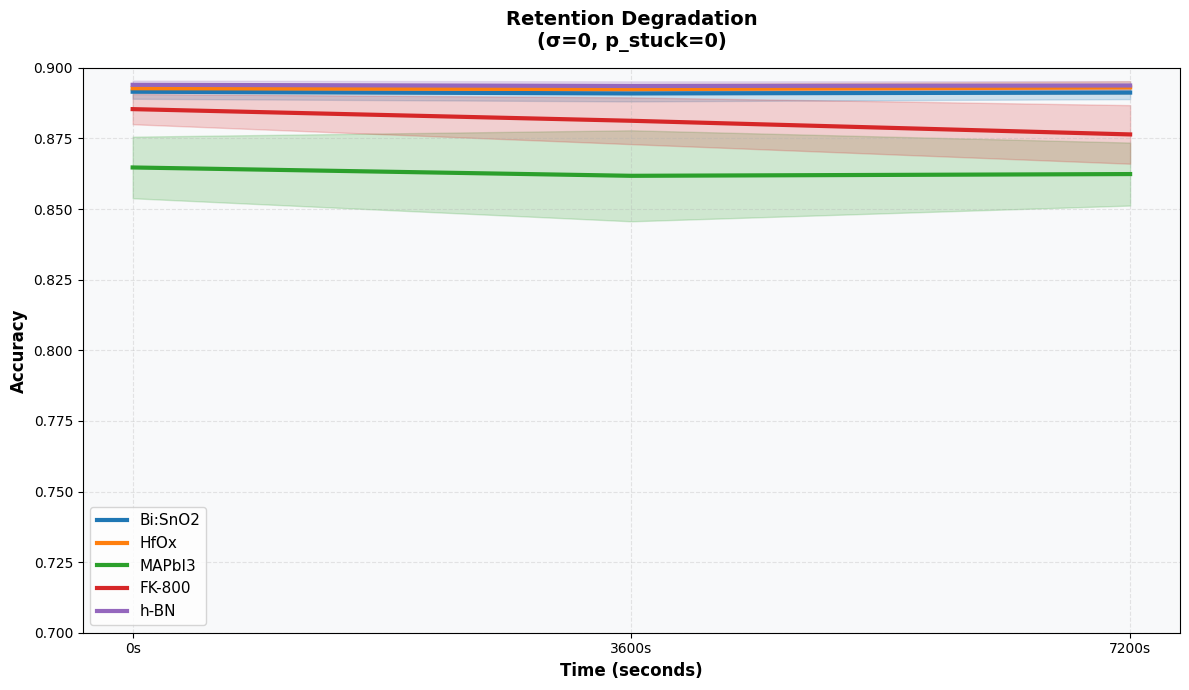

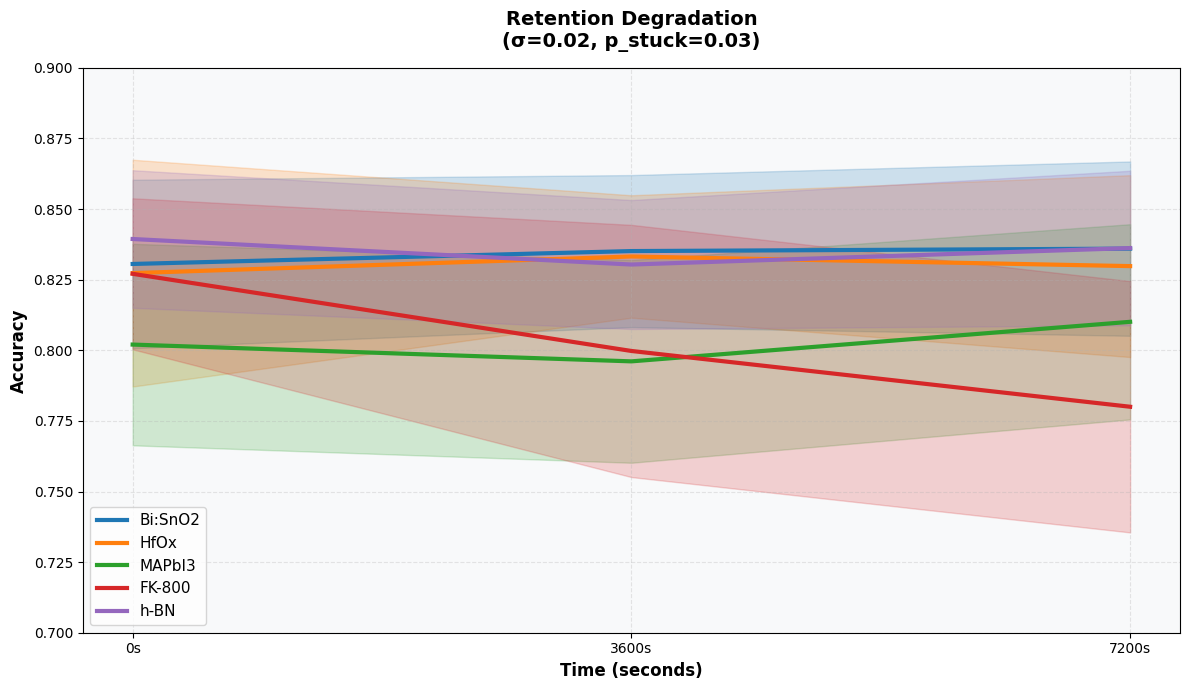


Visualizations completed successfully!


In [57]:
# ==================== CELL 11: GENERATE VISUALIZATIONS ====================

print("Generating visualizations...")

# 1. Material comparison - Accuracy vs Stuck Probability (no markers)
print("1. Material Comparison - Accuracy vs Stuck Probability")
plot_material_comparison(material_results, list(MATERIALS.keys()), sigmas, p_stucks, time_index=0)

# 2. Heatmaps for each material (giữ nguyên)
print("2. Heatmaps for each material")
for material_name in MATERIALS.keys():
    print(f"   - {material_name}")
    plot_heatmaps(material_results, material_name, time_index=0)

# 3. Time degradation analysis (giữ nguyên)
print("3. Time Degradation Analysis")
plot_time_degradation(material_results, list(MATERIALS.keys()), sigma_idx=0, p_stuck_idx=0)
plot_time_degradation(material_results, list(MATERIALS.keys()), sigma_idx=2, p_stuck_idx=2)

print("\nVisualizations completed successfully!")